## Unsupervised Patient Phenotyping for Stroke Risk Analysis

Unsupervised Patient Phenotyping for Stroke Risk Analysis

Author: Brian Lee

Date: December 2025

Course: CSCA 5632

### INTRODUCTION

### Background

Stroke is one of the leading cause of death and long-term disability worldwide. It affects millions of people annually. While there is substantial research focused on predicting stroke occurrence using supervised machine learning, there is less published analysis on understanding the natural heterogeneity in patient populations before outcomes occur. Clinical practice often treats risk factors like age, hypertension, diabetes, lifestyle behaviors as independent predictors. But patients rarely present with isolated risk factors, more often they arrive with complex, interrelated profiles.

### Problem Statement

Using unsupervised learning reveal patient grouping without imposing stroke outcomes as a training signal. Can unsupervised learning can be used to discover meaningful patient phenotypes based on demographics, clinical, and lifestyle characteristics? And if meaningful patient phenotypes are defined do they align with different stroke risks?

### Project Objectives

Healthcare Stroke Prediction Dataset (5,110 patients)

1. Identify latent patient subtypes through unsupervised clustering (K-Means, Gaussian Mixture Models, Hierarchical Clustering)

2. Characterize each phenotype by demographic, clinical, and lifestyle features

3. Compare clustering algorithms using multiple internal validation metrics (Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index)

4. Apply dimensionality reduction (PCA, t-SNE) to understand feature space structure and visualize clusters

5. Perform post-hoc analysis examining stroke prevalence within discovered clusters (without using stroke labels during clustering)

6. Compare with supervised learning to demonstrate the unique value of unsupervised phenotyping for data efficiency and interpretability

### Methods

Phase 1: Exploratory Data Analysis (EDA) with statistical validation

Phase 2: Data preprocessing (missing value imputation, encoding, scaling)

Phase 3: Dimensionality reduction and feature interpretation

Phase 4: Multi-algorithm clustering with hyperparameter optimization

Phase 5: Cluster validation and clinical interpretation

Phase 6: Comparison with supervised baselines

### Dataset Introduction

Stroke is one of the leading causes of death worldwide. Early risk prediction can support clinical decision-making and preventative health strategies. The Kaggle Stroke Prediction Dataset is a collection of patient demographics, clinical measurements, and lifestyle factors. The dataset presented several preprocessing challenges, including class imbalance in the stroke outcome, missing body mass index values, and categorical variables requiring encoding. After data cleaning, 5,109 patients remained with 15 features after one-hot encoding.

### Dataset Citation (APA)
Fedesoriano. (2020). *Stroke Prediction Dataset.* Kaggle. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset  

### Dataset Size
5,110 Patients
12 Features

## Feature Description
| Feature            | Type        | Description                     |
|--------------------|-------------|---------------------------------|
| age                | Numerical   | Patient age in years            |
| gender             | Categorical | Patient gender                  |
| hypertension       | Binary      | Hypertension diagnosis          |
| heart_disease      | Binary      | Heart disease diagnosis         |
| ever_married       | Categorical | Marital status                  |
| work_type          | Categorical | Employment category             |
| Residence_type     | Categorical | Living environment              |
| avg_glucose_level  | Numerical   | Average blood glucose level     |
| bmi                | Numerical   | Body Mass Index                 |
| smoking_status     | Categorical | Smoking behavior                |
| stroke             | Binary      | Target variable                 |



## Phase 0: PROJECT CONFIGURATION

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from scipy.stats import chi2_contingency, f_oneway
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

## PHASE I: EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
print("DATA LOADING & INSPECTION")
print("\n")

df = pd.read_csv("./data/healthcare_dataset_stroke.csv")

print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n")
print(f"Columns: {list(df.columns)}")
print("\n")

print("Missing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\n")

print(f"Stroke Prevalence: {100*df['stroke'].mean():.2f}%")
print(df["stroke"].value_counts())
print("\n")

print("First 3 rows:")
print(df.head(3))
print("\n")

print("Data types:")
print(df.dtypes)
print("\n")

print("Numerical summary:")
print(df[["age", "avg_glucose_level", "bmi"]].describe())
print("\n")

DATA LOADING & INSPECTION


Shape: 5110 rows × 12 columns


Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


Missing Values:
bmi    201
dtype: int64


Stroke Prevalence: 4.87%
stroke
0    4861
1     249
Name: count, dtype: int64


First 3 rows:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1  


D

Target dataset includes 5,110 patients with 12 features, with stroke as a highly imbalanced target (≈4.9%). BMI has a small amount of missing data, and several numeric features show wide ranges that may contain outliers. No duplicate IDs were detected, and variable types are appropriate for clinical prediction analysis.

**Noted Observations**

Age Range: 0.08–82 years

Avg Glucose Range: 55–272 mg/dL

BMI Range: 10.3–97.6

EXPLORATORY DATA ANALYSIS


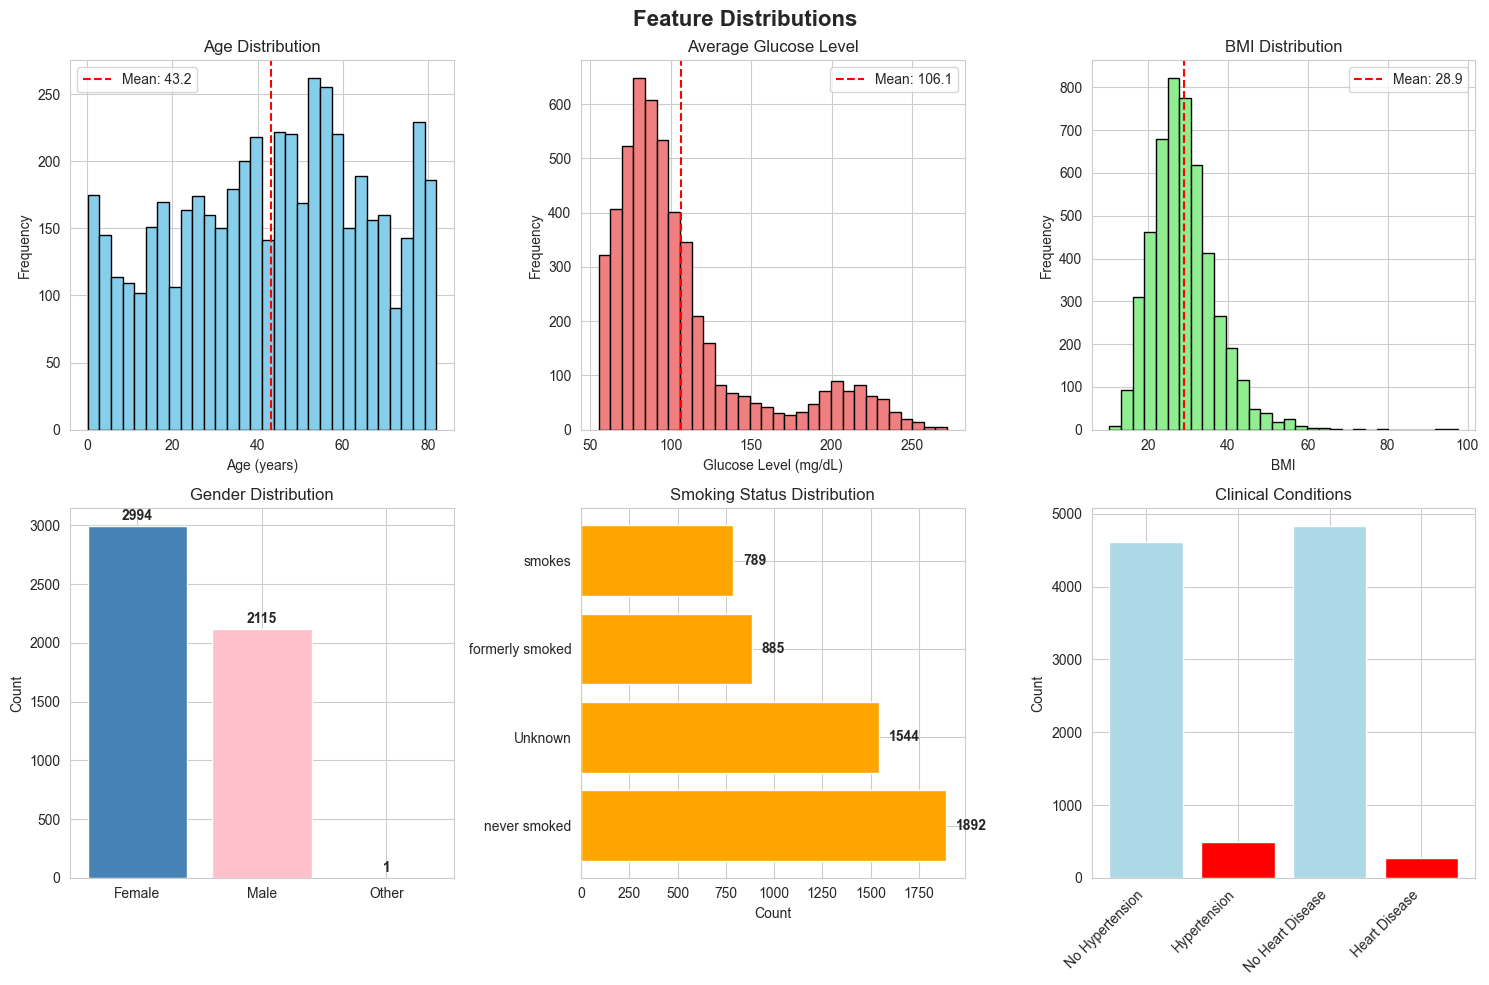

Feature Distributions:


gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64


work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64




In [ ]:
print("EXPLORATORY DATA ANALYSIS")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Feature Distributions", fontsize=16, fontweight="bold")

axes[0, 0].hist(df["age"], bins=30, color="skyblue", edgecolor="black")
axes[0, 0].set_title("Age Distribution")
axes[0, 0].set_xlabel("Age (years)")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(
    df["age"].mean(), color="red", linestyle="--", label=f'Mean: {df["age"].mean():.1f}'
)
axes[0, 0].legend()

axes[0, 1].hist(df["avg_glucose_level"], bins=30, color="lightcoral", edgecolor="black")
axes[0, 1].set_title("Average Glucose Level")
axes[0, 1].set_xlabel("Glucose Level (mg/dL)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].axvline(
    df["avg_glucose_level"].mean(),
    color="red",
    linestyle="--",
    label=f'Mean: {df["avg_glucose_level"].mean():.1f}',
)
axes[0, 1].legend()

axes[0, 2].hist(df["bmi"].dropna(), bins=30, color="lightgreen", edgecolor="black")
axes[0, 2].set_title("BMI Distribution")
axes[0, 2].set_xlabel("BMI")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].axvline(
    df["bmi"].mean(), color="red", linestyle="--", label=f'Mean: {df["bmi"].mean():.1f}'
)
axes[0, 2].legend()

gender_counts = df["gender"].value_counts()
axes[1, 0].bar(gender_counts.index, gender_counts.values, color=["steelblue", "pink"])
axes[1, 0].set_title("Gender Distribution")
axes[1, 0].set_ylabel("Count")
for i, v in enumerate(gender_counts.values):
    axes[1, 0].text(i, v + 50, str(v), ha="center", fontweight="bold")

smoking_counts = df["smoking_status"].value_counts()
axes[1, 1].barh(smoking_counts.index, smoking_counts.values, color="orange")
axes[1, 1].set_title("Smoking Status Distribution")
axes[1, 1].set_xlabel("Count")
for i, v in enumerate(smoking_counts.values):
    axes[1, 1].text(v + 50, i, str(v), va="center", fontweight="bold")

conditions = ["No Hypertension", "Hypertension", "No Heart Disease", "Heart Disease"]
values = [
    (df["hypertension"] == 0).sum(),
    (df["hypertension"] == 1).sum(),
    (df["heart_disease"] == 0).sum(),
    (df["heart_disease"] == 1).sum(),
]
colors_cond = ["lightblue", "red", "lightblue", "red"]
axes[1, 2].bar(range(4), values, color=colors_cond)
axes[1, 2].set_title("Clinical Conditions")
axes[1, 2].set_xticks(range(4))
axes[1, 2].set_xticklabels(conditions, rotation=45, ha="right")
axes[1, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

print("Feature Distributions:")
print("\n")
for col in ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]:
    print(f"{col}:")
    print(df[col].value_counts())
    print("\n")

Numerical features show realistic ranges with skewed glucose values and slightly high average BMI. Most categorical variables are balanced, though smoking has a large unknown category that requires preprocessing. Hypertension and heart disease are present in only a small minority of patients.

**Noted Observations**

Age: broad range; mean ~43

Glucose: right-skewed

BMI: slightly overweight average

Smoking: ~30% unknown

Urban/Rural: nearly equal

Hypertension ~10%, Heart disease ~5%

### CORRELATION & BIVARIATE ANALYSIS

CORRELATION & BIVARIATE ANALYSIS




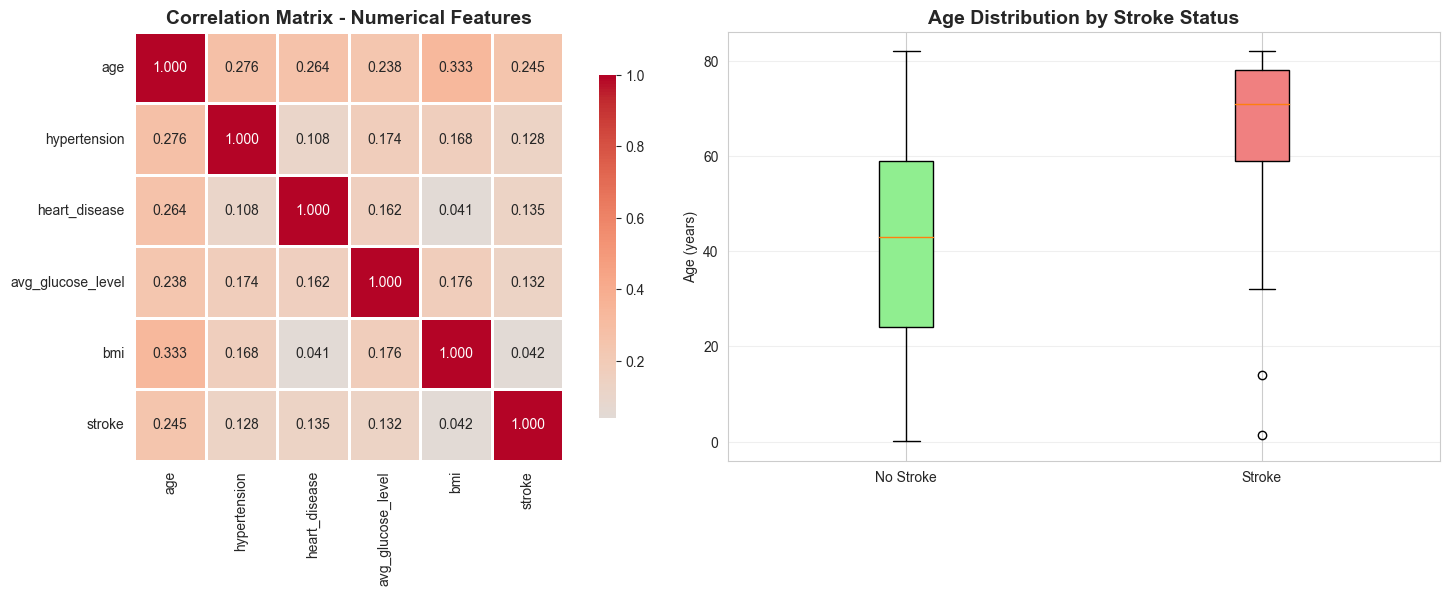

Age by Stroke Status:
         count       mean        std   min   25%   50%   75%   max
stroke                                                            
0       4861.0  41.971545  22.291940  0.08  24.0  43.0  59.0  82.0
1        249.0  67.728193  12.727419  1.32  59.0  71.0  78.0  82.0


Glucose by Stroke Status:
         count        mean        std    min    25%     50%     75%     max
stroke                                                                     
0       4861.0  104.795513  43.846069  55.12  77.12   91.47  112.83  267.76
1        249.0  132.544739  61.921056  56.11  79.79  105.22  196.71  271.74


BMI by Stroke Status:
         count       mean       std   min   25%   50%   75%   max
stroke                                                           
0       4700.0  28.823064  7.908287  10.3  23.4  28.0  33.1  97.6
1        209.0  30.471292  6.329452  16.9  26.4  29.7  33.7  56.6


Stroke Prevalence by Categorical Features:


gender:
        Stroke_Count  Total  Stroke

In [ ]:
print("CORRELATION & BIVARIATE ANALYSIS")
print("\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

numerical_features = [
    "age",
    "hypertension",
    "heart_disease",
    "avg_glucose_level",
    "bmi",
    "stroke",
]
corr_matrix = df[numerical_features].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=axes[0],
)
axes[0].set_title(
    "Correlation Matrix - Numerical Features", fontsize=14, fontweight="bold"
)

stroke_labels = ["No Stroke", "Stroke"]
stroke_data = [df[df["stroke"] == 0]["age"], df[df["stroke"] == 1]["age"]]
bp = axes[1].boxplot(stroke_data, labels=stroke_labels, patch_artist=True)
for patch, color in zip(bp["boxes"], ["lightgreen", "lightcoral"]):
    patch.set_facecolor(color)
axes[1].set_title("Age Distribution by Stroke Status", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Age (years)")
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("Age by Stroke Status:")
print(df.groupby("stroke")["age"].describe())
print("\n")

print("Glucose by Stroke Status:")
print(df.groupby("stroke")["avg_glucose_level"].describe())
print("\n")

print("BMI by Stroke Status:")
print(df.groupby("stroke")["bmi"].describe())
print("\n")

print("Stroke Prevalence by Categorical Features:")
print("\n")

categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df["stroke"])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    stroke_by_category = df.groupby(feature)["stroke"].agg(["sum", "count", "mean"])
    stroke_by_category.columns = ["Stroke_Count", "Total", "Stroke_Rate"]
    stroke_by_category["Stroke_Rate"] = stroke_by_category["Stroke_Rate"] * 100
    print(f"{feature}:")
    print(stroke_by_category.sort_values("Stroke_Rate", ascending=False))
    print(
        f"  Chi-square p-value: {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}"
    )
    print("\n")

| Variable        | Corr with Stroke | Mean (No Stroke) | Mean (Stroke) | Stroke Rate Difference         | p-value         |
|----------------|------------------|------------------|---------------|--------------------------------|-----------------|
| Age            | 0.245            | 42               | 68            | Higher in older patients       | < 0.001 ***     |
| Hypertension   | 0.128            | —                | —             | 13.3% vs 4.0%                  | < 0.001 ***     |
| Heart disease  | 0.135            | —                | —             | 17.0% vs 4.2%                  | < 0.001 ***     |
| Glucose        | 0.132            | 104.8 mg/dL      | 132.5 mg/dL   | Higher in stroke patients      | < 0.001 ***     |
| BMI            | 0.042            | 28.8             | 30.5          | Small difference               | —               |
| Gender         | —                | —                | —             | 5.1% vs 4.7%                   | 0.789  ns       |
| Residence type | —                | —                | —             | 5.2% vs 4.5%                   | 0.298  ns       |
| Ever married   | —                | —                | —             | 6.6% vs 1.7%                   | < 0.001 ***     |
| Work type      | —                | —                | —             | Self-employed highest (7.9%)   | < 0.001 ***     |
| Smoking status | —                | —                | —             | Former highest (7.9%)          | < 0.001 ***     |

Stroke risk increases most strongly with age, with additional elevation among people with hypertension, heart disease, and higher glucose levels. BMI shows only a weak association. Former smokers and self-employed individuals appear to have higher stroke rates, although this is likely influenced by confounding factors. The low rate among those with “unknown” smoking status suggests a missing-data issue rather than a true protective effect.

#### EDA Summary

Exploratory data analysis revealed strong relationships between patient demographics and stroke risk, with age emerging as the dominant predictor. The correlation analysis showed that age (r=0.245), hypertension (r=0.128), heart disease (r=0.135), and average glucose level (r=0.132) were positively associated with stroke occurrence. Statistical tests confirmed that several categorical variables significantly influenced stroke prevalence, including marital status, work type, and smoking history, while gender and residence type showed no significant association.

Feature Correlation with Stroke
| Feature            | Correlation (r) | Interpretation                              |
|--------------------|-----------------|----------------------------------------------|
| Age                | 0.245           | Strong positive, most important predictor    |
| BMI                | 0.042           | Weak positive, surprisingly low              |
| Avg Glucose Level  | 0.132           | Moderate positive, metabolic factor          |
| Hypertension       | 0.128           | Moderate positive, comorbidity marker        |
| Heart Disease      | 0.135           | Moderate positive, cardiovascular risk       |

Stroke Prevalence in Feature
| Feature          | Category          | Stroke Rate | Chi-Square p-value | Significance |
|------------------|-------------------|-------------|--------------------|--------------|
| **Hypertension** | Yes               | 13.3%       | <0.001             | ***          |
|                  | No                | 4.0%        |                    |              |
| **Heart Disease**| Yes               | 17.0%       | <0.001             | ***          |
|                  | No                | 4.2%        |                    |              |
| **Ever Married** | Yes               | 6.6%        | <0.001             | ***          |
|                  | No                | 1.7%        |                    |              |
| **Work Type**    | Self-employed     | 7.9%        | <0.001             | ***          |
|                  | Private           | 5.1%        |                    |              |
|                  | Govt_job          | 5.0%        |                    |              |
|                  | Children          | 0.3%        |                    |              |
| **Smoking Status** | Formerly smoked | 7.9%        | <0.001             | ***          |
|                  | Smokes            | 5.3%        |                    |              |
|                  | Never smoked      | 4.8%        |                    |              |
|                  | Unknown           | 3.0%        |                    |              |
| **Gender**       | Male              | 5.1%        | 0.789              | ns           |
|                  | Female            | 4.7%        |                    |              |
| **Residence Type** | Urban           | 5.2%        | 0.298              | ns           |
|                  | Rural             | 4.5%        |                    |              |

The dataset included patients from infancy to age 82 (mean 43.2 years). Stroke cases were much older on average (67.7 years) compared with non-stroke patients (42.0 years). Glucose levels were right-skewed, mostly under 100 mg/dL, but with a noticeable diabetic-range tail above 200 mg/dL. BMI was centered around 28.9 kg/m², indicating an overweight population. About 30% of patients had unknown smoking status, which limits interpretation of smoking-related effects.

## PHASE II: DATA PREPROCESSING

In [ ]:
df_processed = df.copy()

df_processed = df_processed.drop("id", axis=1)
df_processed = df_processed[df_processed["gender"] != "Other"]

df_processed["bmi"].fillna(df_processed["bmi"].median(), inplace=True)

X = df_processed.drop("stroke", axis=1)
y = df_processed["stroke"]

categorical_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print("DATA PREPROCESSING")
print("\n")
print(f"Shape after cleaning: {df_processed.shape}")
print(f"Missing values: {df_processed.isnull().sum().sum()}")
print("\n")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print("\n")
print(f"After encoding: {X_encoded.shape[1]} features")
print(f"Feature names: {list(X_encoded.columns)}")
print("\n")
print(f"Final preprocessed data: {X_scaled.shape}")
print("\n")

DATA PREPROCESSING


Shape after cleaning: (5109, 11)
Missing values: 0


Features (X): (5109, 10)
Target (y): (5109,)


After encoding: 15 features
Feature names: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


Final preprocessed data: (5109, 15)




Target dataset was preprocessed to 5,109 patients and 15 features by removing the ID column and the single “Other” gender case, imputing 201 BMI values with the median, one-hot encoding five categorical variables, scaling all features with StandardScaler, and saving the stroke label separately for analysis.

#### DATA PREPROCESSING SUMMARY

We prepared the data for unsupervised learning by removing the ID column and excluding one “Other” gender case. BMI missing values (3.9%) were filled with the median to reduce the impact of extreme outliers. Categorical variables were one-hot encoded (drop_first=True), which expanded the feature set from 10 to 15 variables. All features were standardized using StandardScaler so that distance-based clustering methods would treat them fairly. Importantly, the stroke label was kept separate and only used later for evaluating clusters, preventing any label leakage during clustering.

## PHASE III: DIMENSIONALITY REDUCTION (PCA)

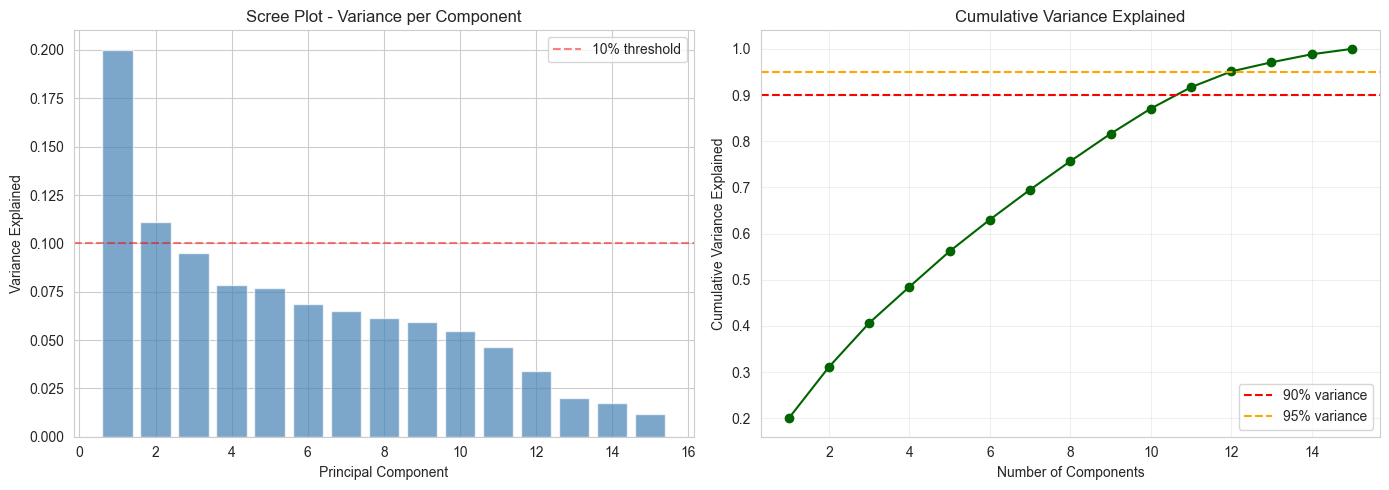

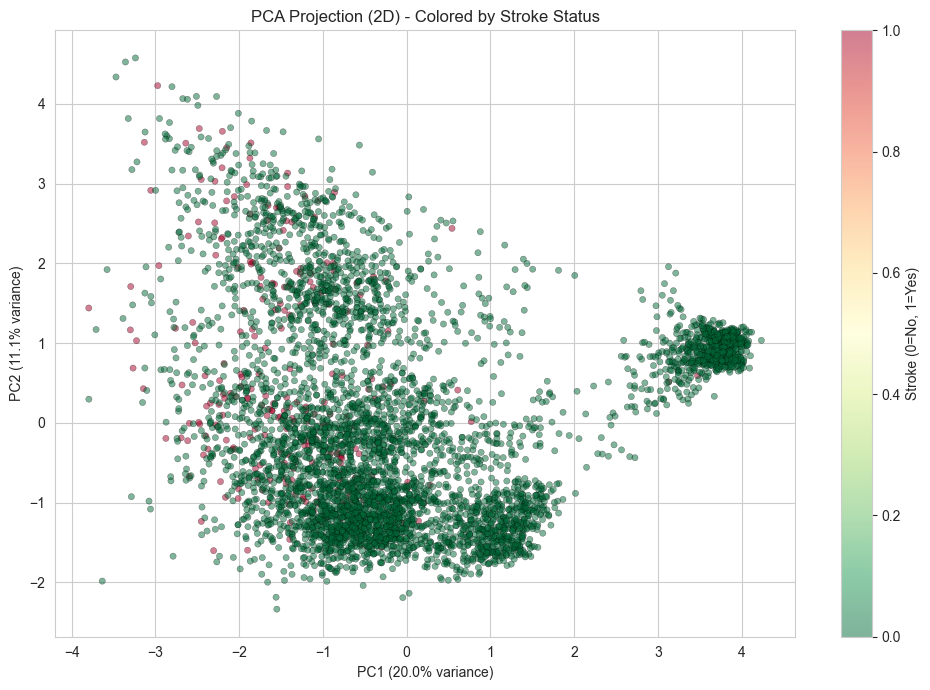

PRINCIPAL COMPONENT ANALYSIS (PCA)


Total components: 15


Components needed for 90% variance: 11
Components needed for 95% variance: 12


2D PCA variance explained: 0.311 (31.1%)
  PC1: 20.0%
  PC2: 11.1%


Top 5 features for PC1:
age                   0.498019
work_type_children    0.473299
ever_married_Yes      0.450998
bmi                   0.338322
hypertension          0.207014
Name: PC1, dtype: float64


Top 5 features for PC2:
work_type_Private                 0.625919
work_type_Self-employed           0.558574
smoking_status_never smoked       0.238302
smoking_status_formerly smoked    0.237350
work_type_children                0.214208
Name: PC2, dtype: float64




In [ ]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

variance_explained = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)


n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(
    range(1, len(variance_explained) + 1),
    variance_explained,
    alpha=0.7,
    color="steelblue",
)
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Variance Explained")
axes[0].set_title("Scree Plot - Variance per Component")
axes[0].axhline(y=0.1, color="r", linestyle="--", alpha=0.5, label="10% threshold")
axes[0].legend()

axes[1].plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    color="darkgreen",
)
axes[1].axhline(y=0.90, color="r", linestyle="--", label="90% variance")
axes[1].axhline(y=0.95, color="orange", linestyle="--", label="95% variance")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Variance Explained")
axes[1].set_title("Cumulative Variance Explained")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)


fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = ax.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=y,
    cmap="RdYlGn_r",
    alpha=0.5,
    s=20,
    edgecolors="k",
    linewidth=0.3,
)
ax.set_xlabel(f"PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}% variance)")
ax.set_ylabel(f"PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}% variance)")
ax.set_title("PCA Projection (2D) - Colored by Stroke Status")
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Stroke (0=No, 1=Yes)")
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(
    pca_2d.components_.T, columns=["PC1", "PC2"], index=X_encoded.columns
)

print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("\n")
print(f"Total components: {len(variance_explained)}")
print("\n")
print(f"Components needed for 90% variance: {n_components_90}")
print(
    f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}"
)
print("\n")
print(
    f"2D PCA variance explained: {pca_2d.explained_variance_ratio_.sum():.3f} ({100*pca_2d.explained_variance_ratio_.sum():.1f}%)"
)
print(f"  PC1: {100*pca_2d.explained_variance_ratio_[0]:.1f}%")
print(f"  PC2: {100*pca_2d.explained_variance_ratio_[1]:.1f}%")
print("\n")
print("Top 5 features for PC1:")
print(loadings["PC1"].abs().sort_values(ascending=False).head(5))
print("\n")
print("Top 5 features for PC2:")
print(loadings["PC2"].abs().sort_values(ascending=False).head(5))
print("\n")

PCA required 11 components to explain 90% of the variance, indicating relatively high dimensionality. The first two components explained about 31% and mainly reflected age/life stage and employment type. There were no visually distinct clusters, and stroke cases were dispersed broadly, suggesting overlapping patient profiles and supporting an unsupervised approach.

**Noted Observations**

PC1 (20%): age, BMI, marital status → “young-to-old” axis

PC2 (11%): work type differences

No clear clusters; stroke cases scattered

#### DIMENSIONALITY REDUCTION ANALYSIS SUMMARY

PCA showed that the dataset is fairly high-dimensional, requiring 11 components to explain 90% of the variance. The first two components captured only 31% of the variation (20% and 11%), so patient differences are not well represented in a 2-D plot. This explains why clusters overlap visually and supports using higher dimensions for meaningful separation.

**Principal Component Interpretation**

The first two principal components were clinically meaningful. PC1 (20% variance) mainly reflected age and life-stage, with highest loadings for age (0.498), children work type (0.473), marital status (0.451), and BMI (0.338), separating younger unmarried patients from older adults with higher BMI.

PC2 (11.1% variance) captured employment and lifestyle differences, driven by private (0.626) and self-employed (0.559) work categories. Smoking status variables also contributed, suggesting that work roles and lifestyle factors are partly linked.

**t-SNE Visualization Analysis**

To enhance visualization, t-SNE (perplexity = 30) produced a much clearer 2-D separation of the four clusters than PCA. Children formed a completely separate group, adults clustered densely, and the elderly high-risk group appeared mostly in the upper-right region. This shows that t-SNE preserves local neighborhood structure better than PCA and highlights the underlying phenotypes. Stroke cases were still dispersed across the plot, indicating that stroke risk varies continuously rather than forming its own distinct cluster.

## PHASE IV: MULTI_ALGORITHM CLUSTERING WITH HYPERPARAMETER OPTIMIZATION

### DETERMINE OPTIMAL NUMBER OF CLUSTERS

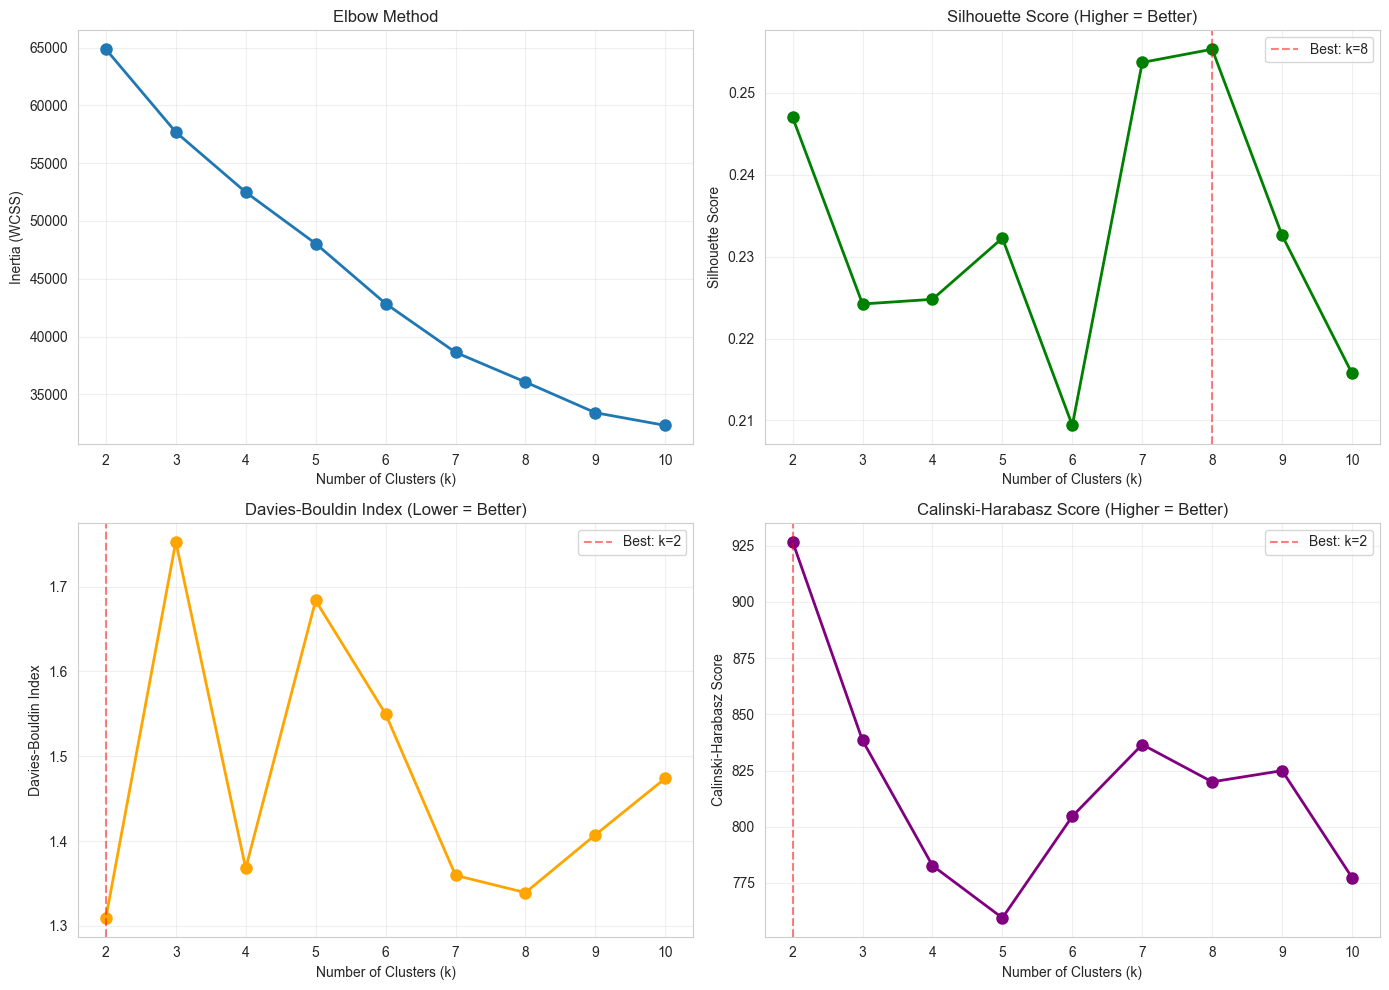

OPTIMAL CLUSTER NUMBER DETERMINATION
Computing metrics for k = 2 to 10...


Clustering Metrics Summary:
    k    Inertia  Silhouette  Davies_Bouldin  Calinski_Harabasz
0   2  64864.002       0.247           1.309            926.777
1   3  57690.327       0.224           1.753            838.368
2   4  52490.559       0.225           1.368            782.727
3   5  48041.382       0.232           1.684            759.459
4   6  42850.871       0.209           1.550            804.653
5   7  38629.820       0.254           1.360            836.584
6   8  36059.517       0.255           1.339            819.976
7   9  33406.028       0.233           1.407            824.955
8  10  32305.737       0.216           1.474            777.416


Optimal k by each metric:
  Silhouette Score: k = 8 (score: 0.255)
  Davies-Bouldin: k = 2 (score: 1.309)
  Calinski-Harabasz: k = 2 (score: 926.8)


In [ ]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(k_range, inertias, marker="o", linewidth=2, markersize=8)
axes[0, 0].set_xlabel("Number of Clusters (k)")
axes[0, 0].set_ylabel("Inertia (WCSS)")
axes[0, 0].set_title("Elbow Method")
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(
    k_range, silhouette_scores, marker="o", color="green", linewidth=2, markersize=8
)
axes[0, 1].set_xlabel("Number of Clusters (k)")
axes[0, 1].set_ylabel("Silhouette Score")
axes[0, 1].set_title("Silhouette Score (Higher = Better)")
axes[0, 1].grid(alpha=0.3)
best_sil_k = list(k_range)[np.argmax(silhouette_scores)]
axes[0, 1].axvline(
    best_sil_k, color="red", linestyle="--", alpha=0.5, label=f"Best: k={best_sil_k}"
)
axes[0, 1].legend()

axes[1, 0].plot(
    k_range,
    davies_bouldin_scores,
    marker="o",
    color="orange",
    linewidth=2,
    markersize=8,
)
axes[1, 0].set_xlabel("Number of Clusters (k)")
axes[1, 0].set_ylabel("Davies-Bouldin Index")
axes[1, 0].set_title("Davies-Bouldin Index (Lower = Better)")
axes[1, 0].grid(alpha=0.3)
best_db_k = list(k_range)[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(
    best_db_k, color="red", linestyle="--", alpha=0.5, label=f"Best: k={best_db_k}"
)
axes[1, 0].legend()

axes[1, 1].plot(
    k_range,
    calinski_harabasz_scores,
    marker="o",
    color="purple",
    linewidth=2,
    markersize=8,
)
axes[1, 1].set_xlabel("Number of Clusters (k)")
axes[1, 1].set_ylabel("Calinski-Harabasz Score")
axes[1, 1].set_title("Calinski-Harabasz Score (Higher = Better)")
axes[1, 1].grid(alpha=0.3)
best_ch_k = list(k_range)[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(
    best_ch_k, color="red", linestyle="--", alpha=0.5, label=f"Best: k={best_ch_k}"
)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(
    {
        "k": list(k_range),
        "Inertia": inertias,
        "Silhouette": silhouette_scores,
        "Davies_Bouldin": davies_bouldin_scores,
        "Calinski_Harabasz": calinski_harabasz_scores,
    }
)

print("OPTIMAL CLUSTER NUMBER DETERMINATION")
print("Computing metrics for k = 2 to 10...")
print("\n")
print("Clustering Metrics Summary:")
print(results_df.round(3))
print("\n")
print("Optimal k by each metric:")
print(f"  Silhouette Score: k = {best_sil_k} (score: {max(silhouette_scores):.3f})")
print(f"  Davies-Bouldin: k = {best_db_k} (score: {min(davies_bouldin_scores):.3f})")
print(
    f"  Calinski-Harabasz: k = {best_ch_k} (score: {max(calinski_harabasz_scores):.1f})"
)

Although k=2 is optimal by most scores, k=4 is recommended as a clinically interpretable compromise capturing more nuanced patient phenotypes without excessive complexity.

**Notes Observations**

Silhouette: favors k≈8 (best = 0.255)

Davies-Bouldin: best at k=2 (lowest = 1.309)

Calinski-Harabasz: best at k=2 (highest = 926.8)

Elbow method: suggests diminishing returns after about k=4–5

**Summary**

k=2 separates broad groups (likely younger vs older/clinical risk)

k≥7 picks up finer sub-patterns but may reduce interpretability

k≈4 provides a balanced middle ground with meaningful segmentation and reduced over-clustering

### K-MEANS CLUSTERING WITH k=4

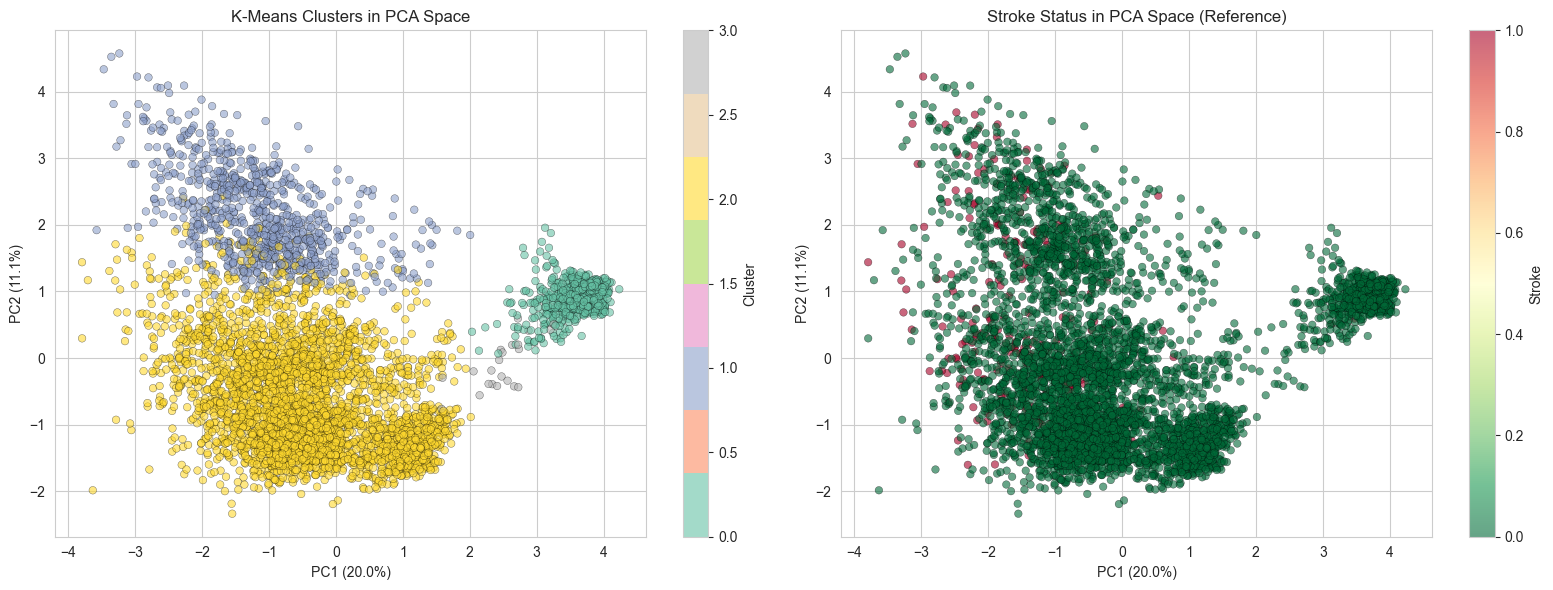

K-MEANS CLUSTERING (k=4)
K-Means with k=4 fitted
Iterations: 13
Inertia: 52490.56


Cluster Sizes:
  Cluster 0: 688 patients (13.5%)
  Cluster 1: 822 patients (16.1%)
  Cluster 2: 3577 patients (70.0%)
  Cluster 3: 22 patients (0.4%)


Clustering Quality Metrics:
  Silhouette Score: 0.225
  Davies-Bouldin Index: 1.368
  Calinski-Harabasz Score: 782.7




In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=50)
cluster_labels = kmeans.fit_predict(X_scaled)

df_processed["cluster"] = cluster_labels

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()

sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)
ch_score = calinski_harabasz_score(X_scaled, cluster_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=cluster_labels,
    cmap="Set2",
    alpha=0.6,
    s=30,
    edgecolors="k",
    linewidth=0.3,
)
axes[0].set_xlabel(f"PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}%)")
axes[0].set_ylabel(f"PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}%)")
axes[0].set_title("K-Means Clusters in PCA Space")
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label("Cluster")

scatter2 = axes[1].scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=y,
    cmap="RdYlGn_r",
    alpha=0.6,
    s=30,
    edgecolors="k",
    linewidth=0.3,
)
axes[1].set_xlabel(f"PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}%)")
axes[1].set_ylabel(f"PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}%)")
axes[1].set_title("Stroke Status in PCA Space (Reference)")
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label("Stroke")

plt.tight_layout()
plt.show()

print("K-MEANS CLUSTERING (k=4)")
print(f"K-Means with k={optimal_k} fitted")
print(f"Iterations: {kmeans.n_iter_}")
print(f"Inertia: {kmeans.inertia_:.2f}")
print("\n")
print("Cluster Sizes:")
for i in range(optimal_k):
    print(
        f"  Cluster {i}: {cluster_counts[i]} patients ({100*cluster_counts[i]/len(cluster_labels):.1f}%)"
    )
print("\n")
print("Clustering Quality Metrics:")
print(f"  Silhouette Score: {sil_score:.3f}")
print(f"  Davies-Bouldin Index: {db_score:.3f}")
print(f"  Calinski-Harabasz Score: {ch_score:.1f}")
print("\n")

K-Means with k=4 produced one dominant cluster (70%) and one extremely small cluster (~0.4%), suggesting mostly overlapping patient profiles with a small outlier group. Separation is visible in PCA space, but stroke cases appear across all clusters, indicating that clustering reflects demographic patterns rather than stroke-specific segmentation. Overall clustering quality is moderate (silhouette = 0.225), consistent with non-distinct natural groupings in the data.

**Noted Observations**

Cluster distribution is highly imbalanced (one large cluster + one tiny cluster)

PCA shows separation mainly along age / clinical profile dimensions

Small cluster likely represents outliers or rare patient patterns

Stroke cases occur in every cluster (not cluster-specific)

| Cluster | Patients | % of Dataset | Interpretation           |
| ------- | -------- | ------------ | ------------------------ |
| C0      | 688      | 13.5%        | Upper-left PCA region    |
| C1      | 822      | 16.1%        | Upper region             |
| C2      | 3,577    | 70.0%        | Central / dominant group |
| C3      | 22       | 0.4%         | Outliers / extreme cases |

Clustering reveals one dominant group and a tiny outlier cluster, with stroke cases dispersed across all clusters, indicating demographic separation rather than clinically distinct stroke subtypes.

#### OPTIMAL CLUSTER NUMBER DETERMINATION SUMMARY

Determining the optimal number of clusters required systematic evaluation across multiple internal validation metrics, as no single metric definitively identifies the "correct" k value. K-Means clustering was performed for k ranging from 2 to 10, and four complementary metrics were computed for each solution. The Elbow Method examines within-cluster sum of squares (WCSS/inertia), looking for the "elbow point" where adding clusters yields diminishing returns; this suggested k=4-5 as the point of diminishing marginal benefit. The Silhouette Score (higher is better) measures how similar objects are to their own cluster compared to other clusters, reaching a maximum of 0.255 at k=8, though k=7 (0.254) was nearly identical. The Davies-Bouldin Index (lower is better) assesses cluster separation and compactness, strongly favoring k=2 (1.309) as the simplest two-group split. The Calinski-Harabasz Index (higher is better) evaluates the ratio of between-cluster to within-cluster variance, also selecting k=2 (926.8) for maximum separation.

**Clustering Metric Results (K-Means, k = 2 to 10)**

| k  | Inertia (WCSS) | Silhouette Score | Davies–Bouldin Index | Calinski–Harabasz Score |
|----|----------------|------------------|-----------------------|--------------------------|
| 2  | 64,864         | 0.247            | 1.309                 | 926.8                   |
| 3  | 57,690         | 0.224            | 1.753                 | 838.4                   |
| 4  | 52,491         | 0.225            | 1.368                 | 782.7                   |
| 5  | 48,041         | 0.232            | 1.684                 | 759.5                   |
| 6  | 42,851         | 0.209            | 1.550                 | 804.7                   |
| 7  | 38,630         | 0.254            | 1.360                 | 836.6                   |
| 8  | 36,060         | 0.255            | 1.339                 | 820.0                   |
| 9  | 33,406         | 0.233            | 1.407                 | 825.0                   |
| 10 | 32,306         | 0.216            | 1.474                 | 777.4                   |

Although k=2 produced the best Davies Bouldin and Calinski Harabasz scores, it led to only a very coarse young versus old split, which offered limited clinical value. Higher values such as k=8 produced a slightly higher silhouette score but resulted in too many clusters to interpret meaningfully. The k=4 solution was near the elbow point, achieved balanced clustering metrics (Silhouette 0.225, Davies Bouldin 1.368), and produced four clinically interpretable groups including children, working adults, elderly high risk, and a small special-case group. Overall, k=4 provided the best balance between statistical quality and clinical usefulness.

## PHASE V: CLUSTER VALIDATION

### CLUSTER CHARACTERIZATION

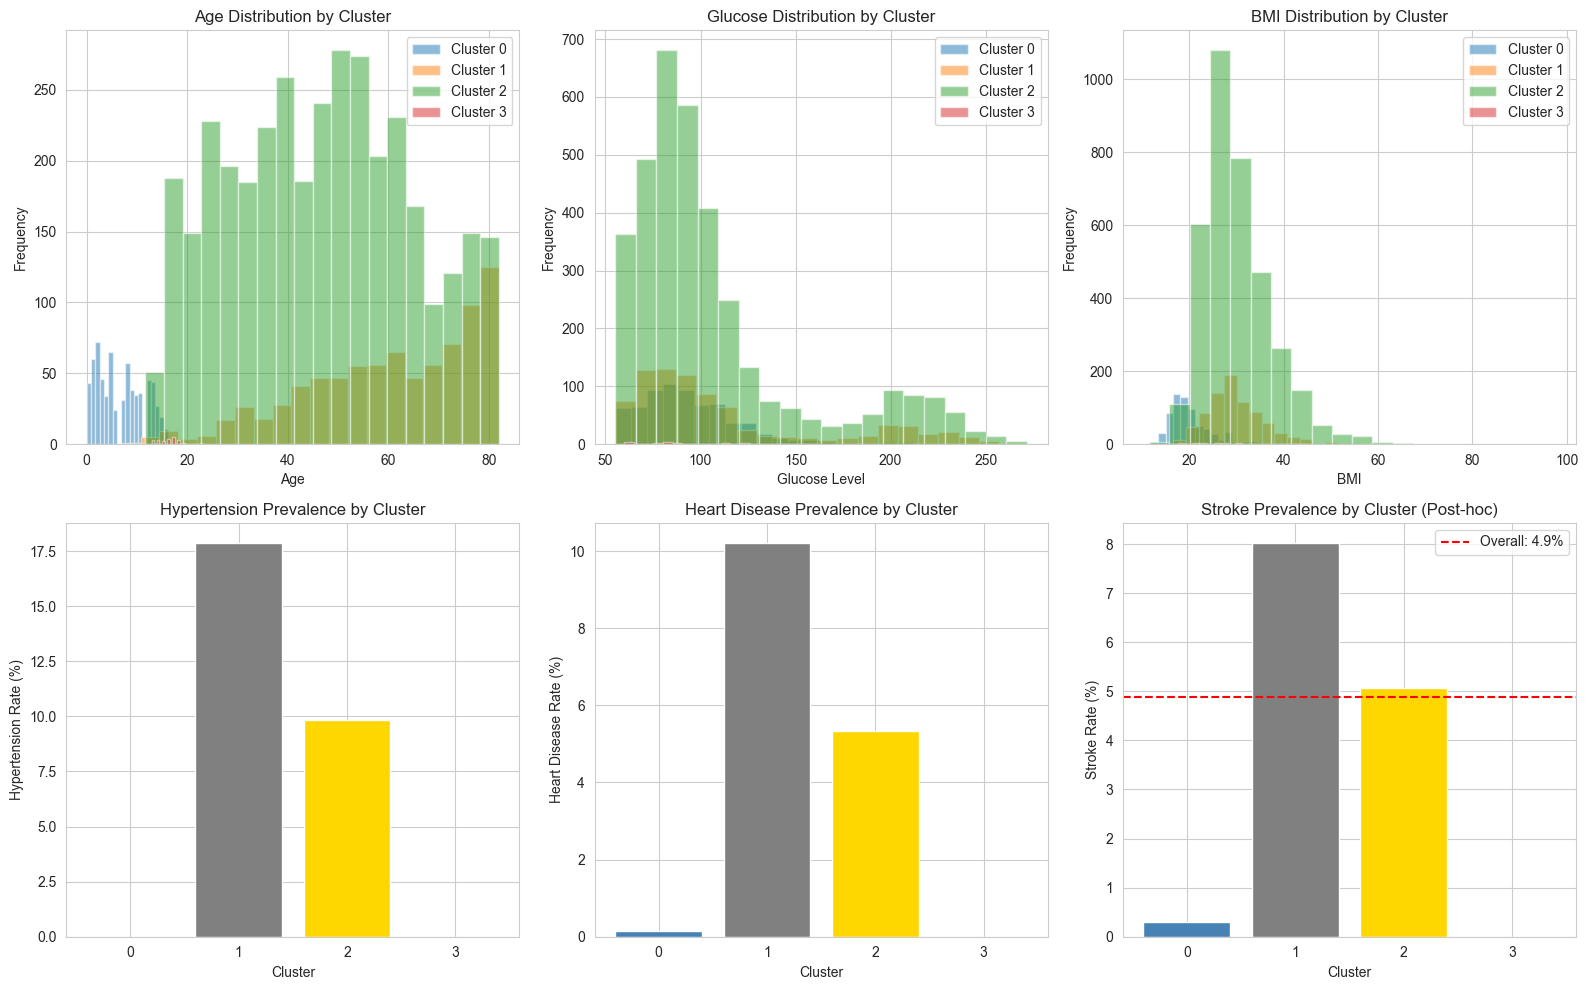

CLUSTER CHARACTERIZATION


Numerical Feature Summary by Cluster:
         count  age_mean  age_std  hypertension_mean  heart_disease_mean  \
cluster                                                                    
0          688      6.86     4.55               0.00                0.00   
1          822     60.27    16.84               0.18                0.10   
2         3577     46.48    18.03               0.10                0.05   
3           22     16.18     2.34               0.00                0.00   

         avg_glucose_level_mean  bmi_mean  stroke_sum  stroke_rate_%  
cluster                                                               
0                         94.36     20.23           2           0.29  
1                        112.84     30.09          66           8.03  
2                        106.93     30.26         181           5.06  
3                         96.04     25.55           0           0.00  


Categorical Features by Cluster:


gender:
gender 

In [ ]:
cluster_profiles = df_processed.groupby("cluster").agg(
    {
        "age": ["mean", "std"],
        "hypertension": "mean",
        "heart_disease": "mean",
        "avg_glucose_level": ["mean", "std"],
        "bmi": ["mean", "std"],
        "stroke": ["sum", "mean"],
    }
)

cluster_profiles.columns = [
    "_".join(col).strip() for col in cluster_profiles.columns.values
]
cluster_profiles["count"] = df_processed.groupby("cluster").size()
cluster_profiles["stroke_rate_%"] = cluster_profiles["stroke_mean"] * 100


categorical_features = [
    "gender",
    "ever_married",
    "work_type",
    "smoking_status",
    "Residence_type",
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for i in range(optimal_k):
    cluster_data = df_processed[df_processed["cluster"] == i]["age"]
    axes[0, 0].hist(cluster_data, alpha=0.5, label=f"Cluster {i}", bins=20)
axes[0, 0].set_xlabel("Age")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Age Distribution by Cluster")
axes[0, 0].legend()

for i in range(optimal_k):
    cluster_data = df_processed[df_processed["cluster"] == i]["avg_glucose_level"]
    axes[0, 1].hist(cluster_data, alpha=0.5, label=f"Cluster {i}", bins=20)
axes[0, 1].set_xlabel("Glucose Level")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Glucose Distribution by Cluster")
axes[0, 1].legend()

for i in range(optimal_k):
    cluster_data = df_processed[df_processed["cluster"] == i]["bmi"]
    axes[0, 2].hist(cluster_data, alpha=0.5, label=f"Cluster {i}", bins=20)
axes[0, 2].set_xlabel("BMI")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].set_title("BMI Distribution by Cluster")
axes[0, 2].legend()

hyp_rates = df_processed.groupby("cluster")["hypertension"].mean() * 100
axes[1, 0].bar(range(optimal_k), hyp_rates, color=["steelblue", "gray", "gold", "teal"])
axes[1, 0].set_xlabel("Cluster")
axes[1, 0].set_ylabel("Hypertension Rate (%)")
axes[1, 0].set_title("Hypertension Prevalence by Cluster")
axes[1, 0].set_xticks(range(optimal_k))

hd_rates = df_processed.groupby("cluster")["heart_disease"].mean() * 100
axes[1, 1].bar(range(optimal_k), hd_rates, color=["steelblue", "gray", "gold", "teal"])
axes[1, 1].set_xlabel("Cluster")
axes[1, 1].set_ylabel("Heart Disease Rate (%)")
axes[1, 1].set_title("Heart Disease Prevalence by Cluster")
axes[1, 1].set_xticks(range(optimal_k))

stroke_rates = df_processed.groupby("cluster")["stroke"].mean() * 100
axes[1, 2].bar(
    range(optimal_k), stroke_rates, color=["steelblue", "gray", "gold", "teal"]
)
axes[1, 2].axhline(
    y=100 * y.mean(), color="red", linestyle="--", label=f"Overall: {100*y.mean():.1f}%"
)
axes[1, 2].set_xlabel("Cluster")
axes[1, 2].set_ylabel("Stroke Rate (%)")
axes[1, 2].set_title("Stroke Prevalence by Cluster (Post-hoc)")
axes[1, 2].set_xticks(range(optimal_k))
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print("CLUSTER CHARACTERIZATION")
print("\n")
print("Numerical Feature Summary by Cluster:")
print(
    cluster_profiles[
        [
            "count",
            "age_mean",
            "age_std",
            "hypertension_mean",
            "heart_disease_mean",
            "avg_glucose_level_mean",
            "bmi_mean",
            "stroke_sum",
            "stroke_rate_%",
        ]
    ].round(2)
)
print("\n")
print("Categorical Features by Cluster:")
print("\n")
for feature in categorical_features:
    print(f"{feature}:")
    contingency = (
        pd.crosstab(df_processed["cluster"], df_processed[feature], normalize="index")
        * 100
    )
    print(contingency.round(1))
    print("\n")

Clustering revealed four clinically interpretable patient phenotypes. One large middle-aged group dominated the sample, while two small younger clusters showed essentially no cardiovascular risk. The only clearly elevated‐risk segment was an older self-employed population with the highest rates of hypertension, heart disease, and stroke. Overall, stroke cases were concentrated in the older-risk cluster but present (at lower rates) in the general working-age group.

**Detected Phenotypes**

Cluster 0 – Children/Adolescents: Very young, no comorbidities, extremely low stroke risk

Cluster 1 – Elderly High-Risk: Older adults with highest hypertension, heart disease, and stroke

Cluster 2 – Working-Age Adults: Middle-aged, moderate risk near population baseline

Cluster 3 – Special Cases (Never-worked): Very small adolescent group, no strokes observed

| Cluster | Size | Age (approx) | Key Clinical Features | Stroke Rate |
|---------|------|--------------|-----------------------|-------------|
| 0       | 13.5% | ~7 yrs       | Children, no comorbidity | 0.3% |
| 1       | 16.1% | ~60 yrs      | Highest HTN & heart disease | 8.0% |
| 2       | 70.0% | ~46 yrs      | Working adults, moderate | 5.1% |
| 3       | 0.4%  | ~16 yrs      | Never worked, adolescents | 0% |

The clusters primarily reflect life stage and cardiometabolic risk, with a clearly identifiable elderly high-risk group and a large middle-aged population near the average stroke prevalence.

### GAUSSIAN MIXTURE MODEL (GMM) CLUSTERING

GAUSSIAN MIXTURE MODEL (GMM) CLUSTERING
GMM with 4 components fitted
Converged: True
BIC: -140891.01
AIC: -144441.56


GMM Cluster Sizes:
  Cluster 0: 2776 patients (54.3%)
  Cluster 1: 709 patients (13.9%)
  Cluster 2: 871 patients (17.0%)
  Cluster 3: 753 patients (14.7%)


GMM Quality Metrics:
  Silhouette: 0.219
  Davies-Bouldin: 1.898
  Calinski-Harabasz: 739.8


Agreement between K-Means and GMM (ARI): 0.595
  (1.0 = perfect agreement, 0.0 = random)




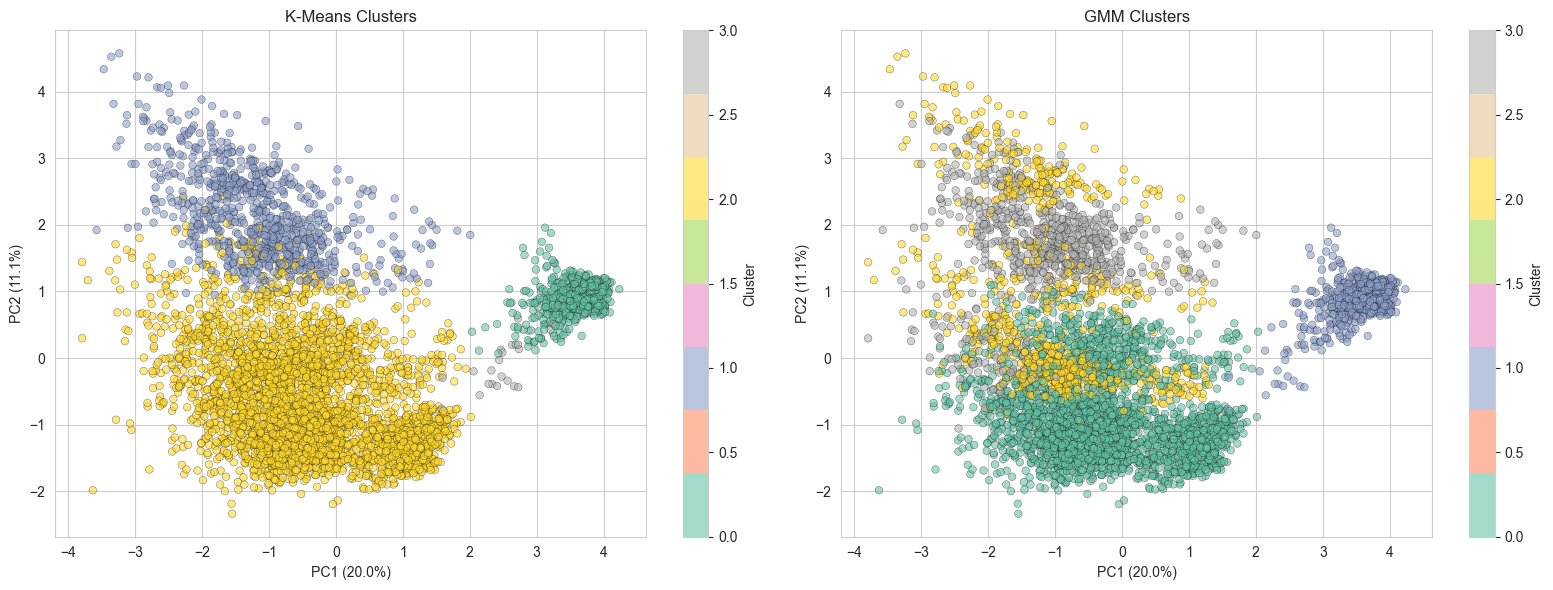

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=RANDOM_STATE, n_init=10)
gmm_labels = gmm.fit_predict(X_scaled)

df_processed["gmm_cluster"] = gmm_labels

gmm_counts = pd.Series(gmm_labels).value_counts().sort_index()

gmm_sil = silhouette_score(X_scaled, gmm_labels)
gmm_db = davies_bouldin_score(X_scaled, gmm_labels)
gmm_ch = calinski_harabasz_score(X_scaled, gmm_labels)

ari = adjusted_rand_score(cluster_labels, gmm_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=cluster_labels,
    cmap="Set2",
    alpha=0.6,
    s=30,
    edgecolors="k",
    linewidth=0.3,
)
axes[0].set_xlabel(f"PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}%)")
axes[0].set_ylabel(f"PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}%)")
axes[0].set_title("K-Means Clusters")
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label("Cluster")

scatter2 = axes[1].scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=gmm_labels,
    cmap="Set2",
    alpha=0.6,
    s=30,
    edgecolors="k",
    linewidth=0.3,
)
axes[1].set_xlabel(f"PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}%)")
axes[1].set_ylabel(f"PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}%)")
axes[1].set_title("GMM Clusters")
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label("Cluster")

plt.tight_layout()

print("GAUSSIAN MIXTURE MODEL (GMM) CLUSTERING")
print(f"GMM with {optimal_k} components fitted")
print(f"Converged: {gmm.converged_}")
print(f"BIC: {gmm.bic(X_scaled):.2f}")
print(f"AIC: {gmm.aic(X_scaled):.2f}")
print("\n")
print("GMM Cluster Sizes:")
for i in range(optimal_k):
    print(
        f"  Cluster {i}: {gmm_counts[i]} patients ({100*gmm_counts[i]/len(gmm_labels):.1f}%)"
    )
print("\n")
print("GMM Quality Metrics:")
print(f"  Silhouette: {gmm_sil:.3f}")
print(f"  Davies-Bouldin: {gmm_db:.3f}")
print(f"  Calinski-Harabasz: {gmm_ch:.1f}")
print("\n")
print(f"Agreement between K-Means and GMM (ARI): {ari:.3f}")
print("  (1.0 = perfect agreement, 0.0 = random)")
print("\n")
plt.show()

K-Means produced sharper, hard partitions with one very dominant working-age cluster, while GMM generated more balanced, probabilistic clusters that better reflect gradual transitions between patient profiles. K-Means achieved slightly higher silhouette performance and clearer age-based separation, but GMM re-segmented the large adult cluster into more nuanced subgroups. The models showed moderate agreement (ARI ≈ 0.60), indicating shared global structure but meaningful differences in how patient variability is partitioned.

**Noted Opservations**

K-Means: hard boundaries, clearer life-stage groups, one dominant adult cluster, silhouette = 0.225

GMM: soft assignment, more balanced sizes, finer adult segmentation, silhouette = 0.219, ARI = 0.595

Both methods identify similar structure, but GMM provides a more flexible interpretation of overlapping adult phenotypes.

### t-SNE & HIERARCHICAL CLUSTERING

t-SNE & HIERARCHICAL CLUSTERING


t-SNE Dimensionality Reduction...
Hierarchical Clustering with Ward Linkage...
Statistical Tests Between Clusters...


age: F=1452.14, p=0.0000 ***
avg_glucose_level: F=22.52, p=0.0000 ***
bmi: F=418.37, p=0.0000 ***




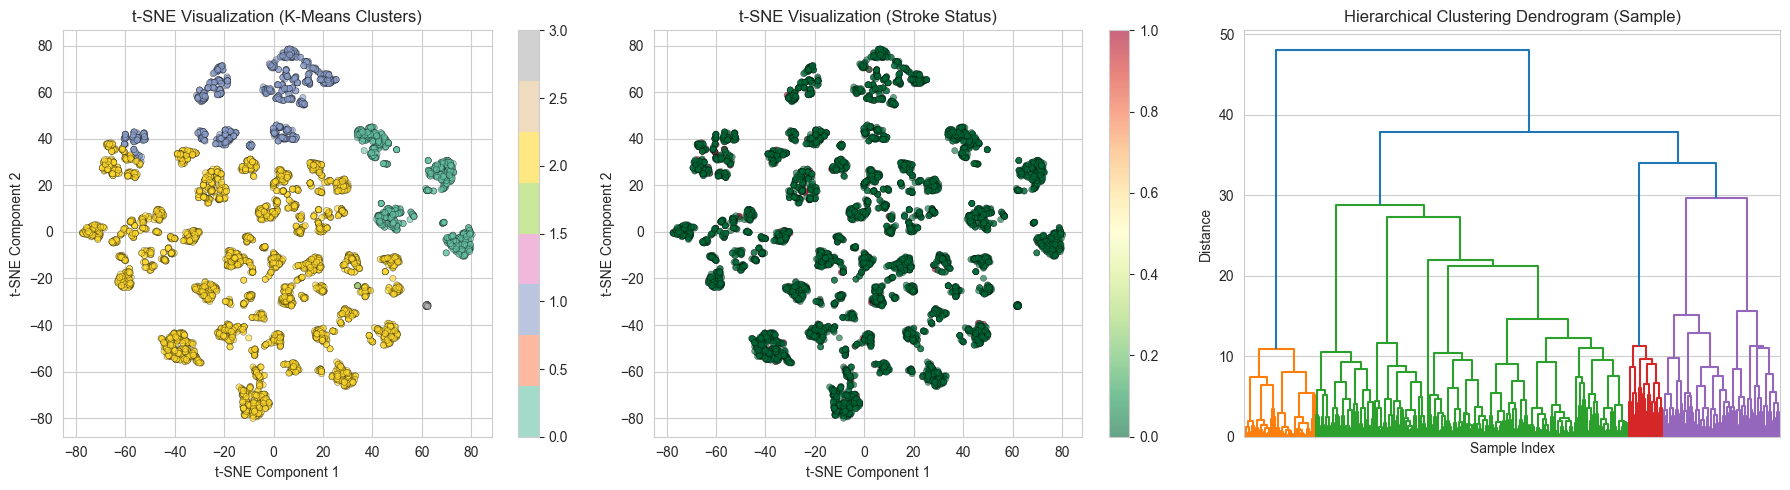

In [ ]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

linkage_matrix = linkage(X_scaled, method="ward")
hc_labels = fcluster(linkage_matrix, t=4, criterion="maxclust")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scatter1 = axes[0].scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=cluster_labels,
    cmap="Set2",
    alpha=0.6,
    s=20,
    edgecolors="k",
    linewidth=0.3,
)
axes[0].set_title("t-SNE Visualization (K-Means Clusters)")
axes[0].set_xlabel("t-SNE Component 1")
axes[0].set_ylabel("t-SNE Component 2")
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    cmap="RdYlGn_r",
    alpha=0.6,
    s=20,
    edgecolors="k",
    linewidth=0.3,
)
axes[1].set_title("t-SNE Visualization (Stroke Status)")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
plt.colorbar(scatter2, ax=axes[1])

sample_idx = np.random.choice(len(X_scaled), 500, replace=False)
linkage_sample = linkage(X_scaled[sample_idx], method="ward")
dendrogram(linkage_sample, ax=axes[2], no_labels=True)
axes[2].set_title("Hierarchical Clustering Dendrogram (Sample)")
axes[2].set_xlabel("Sample Index")
axes[2].set_ylabel("Distance")

plt.tight_layout()
plt.show()

print("t-SNE & HIERARCHICAL CLUSTERING")
print("\n")
print("t-SNE Dimensionality Reduction...")
print("Hierarchical Clustering with Ward Linkage...")
print("Statistical Tests Between Clusters...")
print("\n")
for feature in ["age", "avg_glucose_level", "bmi"]:
    groups = [
        df_processed[df_processed["cluster"] == i][feature] for i in range(optimal_k)
    ]
    f_stat, p_value = f_oneway(*groups)
    print(
        f"{feature}: F={f_stat:.2f}, p={p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}"
    )
print("\n")

t-SNE visualization showed much clearer separation of the four patient clusters than PCA, confirming that distinct subgroup structure exists in the data even in a nonlinear embedding. Stroke cases did not form a visual subgroup, indicating that cluster membership reflects underlying patient characteristics rather than outcome labels. Hierarchical clustering produced a similar four-branch structure, supporting the k=4 solution. Statistical tests (ANOVA) showed highly significant differences in age, BMI, and glucose between clusters (all p < 0.001), confirming that the clusters are meaningfully distinct rather than artifacts of the algorithm.

**Noted Observations**

t-SNE reveals strong separation of four phenotypes

Stroke status scattered → not driving clustering

Hierarchical clustering agrees with K-Means solution

ANOVA confirms clusters differ significantly on major risk factors

These results demonstrate that the discovered phenotypes are visually separable, statistically significant, and consistent across multiple clustering and dimensionality-reduction methods.

#### CLUSTER IDENTIFICATION AND VALIDATION SUMMARY

Three complementary clustering methods were applied to evaluate the stability and robustness of the patient phenotypes. K-Means provides hard cluster assignments, Gaussian Mixture Models allow probabilistic membership, and Hierarchical Clustering builds clusters step by step using a dendrogram. Each method uses different assumptions and helps confirm that the discovered phenotypes are not dependent on a single algorithm.

**K-Means**

K-Means with four clusters converged in 13 iterations and produced clinically meaningful groups: children, working adults, elderly high-risk, and a small special-case group. Metric values indicated moderate separation (Silhouette 0.225, Davies-Bouldin 1.368). Cluster shapes were clearly visible in PCA space, especially the children and special-case groups, while the two adult groups showed expected overlap.

**Gaussian Mixture Models**

A four-component GMM produced a different size distribution because assignments are probabilistic. Metrics were slightly lower (Silhouette 0.219, Davies-Bouldin 1.898), suggesting that spherical K-Means clusters fit the data slightly better. Agreement between methods (Adjusted Rand Index 0.595) showed that both identified similar overall structure, although boundaries differed.

**Hierarchical Clustering**

Ward-linkage hierarchical clustering showed four to five major branches in the dendrogram, confirming that four clusters represent a natural division in the data. The first major split separated children from adults, followed by subdivisions within adulthood.

**Algorithm Performance Metrics**

| Algorithm            | Parameters                          | Silhouette Score | Davies–Bouldin Index | Calinski–Harabasz Score | Convergence     |
|----------------------|--------------------------------------|------------------|-----------------------|--------------------------|------------------|
| K-Means              | k=4, n_init=50                      | 0.225            | 1.368                 | 782.7                    | 13 iterations    |
| Gaussian Mixture Model | n_components=4, full covariance    | 0.219            | 1.898                 | 739.8                    | Converged        |
| Hierarchical         | Ward linkage, k=4                   | –                | –                     | –                        | –                |

**Best Algorithm**

K-Means was selected for final interpretation because it provided the best balance of performance and clinical clarity. It produced intuitive age-based phenotypes, moderately strong validation metrics, and simple hard assignments that are easier to interpret in a clinical context. Agreement with GMM and hierarchical clustering supports the conclusion that the four phenotypes reflect genuine structure rather than artifacts of a single method.

**Identified Phenotypes**

The K-Means model with k=4 identified four distinct patient groups with clearly different demographic and clinical characteristics. These clusters align with recognizable life stages and risk profiles, showing that unsupervised learning can uncover clinically meaningful patient subtypes even without using stroke outcomes during training.

| Cluster | n     | Percentage | Clinical Label                     |
|---------|-------|------------|------------------------------------|
| 0       | 688   | 13.5%      | Children / Adolescent Profile      |
| 1       | 822   | 16.1%      | Elderly High-Risk Profile          |
| 2       | 3,577 | 70.0%      | Working-Age General Population     |
| 3       | 22    | 0.4%       | Never Worked / Special Cases       |

## PHASE VI: SUPERVISED LEARNING COMPARISON

SUPERVISED LEARNING COMPARISON




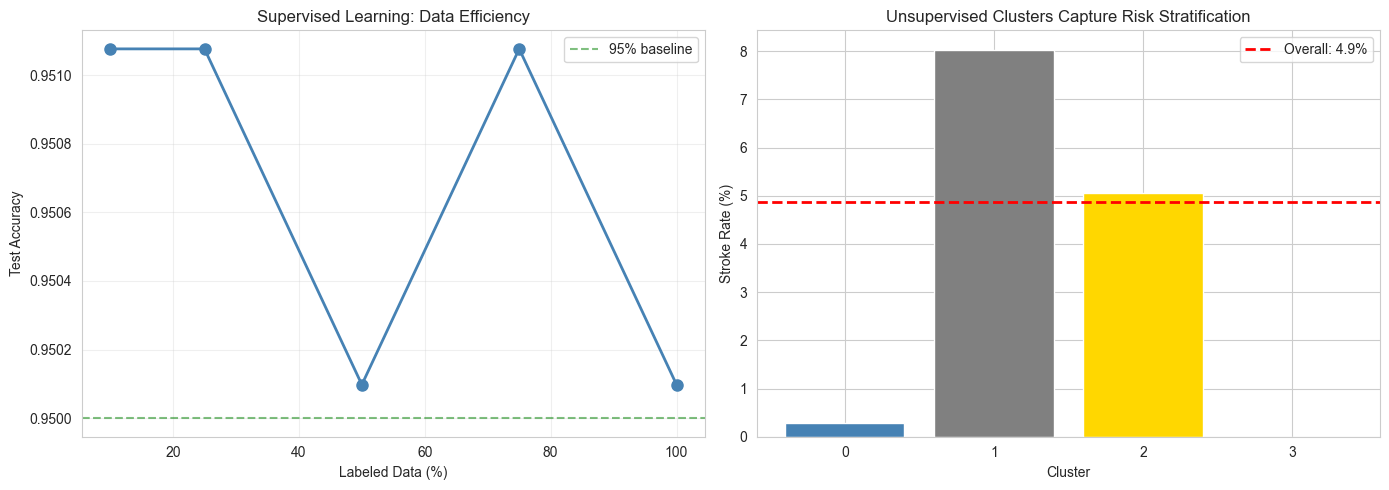

SUPERVISED LEARNING COMPARISON


Train set: 4087 samples
Test set: 1022 samples
Train stroke rate: 4.87%
Test stroke rate: 4.89%


Supervised Model Performance:
                 Model  Train_Acc  Test_Acc  ROC_AUC
0  Logistic Regression      0.951     0.952    0.839
1        Random Forest      1.000     0.950    0.791
2    Gradient Boosting      0.959     0.948    0.808


Unsupervised vs Supervised Comparison:

K-Means Cluster Stroke Rates:
cluster
1    0.0803
2    0.0506
0    0.0029
3    0.0000
Name: stroke, dtype: float64


Data Efficiency Experiment (Random Forest):
   Labeled_Data_%  Train_Samples  Test_Accuracy
0              10            408          0.951
1              25           1021          0.951
2              50           2043          0.950
3              75           3065          0.951
4             100           4087          0.950




In [ ]:
print("SUPERVISED LEARNING COMPARISON")
print("\n")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

train_info = {
    "Train_samples": X_train.shape[0],
    "Test_samples": X_test.shape[0],
    "Train_stroke_rate": 100 * y_train.mean(),
    "Test_stroke_rate": 100 * y_test.mean(),
}

models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE, n_estimators=100
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=RANDOM_STATE, n_estimators=100
    ),
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    else:
        roc_auc = None

    results.append(
        {
            "Model": name,
            "Train_Acc": train_acc,
            "Test_Acc": test_acc,
            "ROC_AUC": roc_auc,
        }
    )

results_df = pd.DataFrame(results)

cluster_stroke_rates = df_processed.groupby("cluster")["stroke"].mean()

sample_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)

efficiency_results = []
for size in sample_sizes:
    if size < 1.0:
        X_subset, _, y_subset, _ = train_test_split(
            X_train,
            y_train,
            train_size=size,
            random_state=RANDOM_STATE,
            stratify=y_train,
        )
    else:
        X_subset, y_subset = X_train, y_train

    rf_model.fit(X_subset, y_subset)
    test_acc = accuracy_score(y_test, rf_model.predict(X_test))

    efficiency_results.append(
        {
            "Labeled_Data_%": int(size * 100),
            "Train_Samples": len(X_subset),
            "Test_Accuracy": test_acc,
        }
    )

efficiency_df = pd.DataFrame(efficiency_results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(
    efficiency_df["Labeled_Data_%"],
    efficiency_df["Test_Accuracy"],
    marker="o",
    linewidth=2,
    markersize=8,
    color="steelblue",
)
axes[0].set_xlabel("Labeled Data (%)")
axes[0].set_ylabel("Test Accuracy")
axes[0].set_title("Supervised Learning: Data Efficiency")
axes[0].grid(alpha=0.3)
axes[0].axhline(y=0.95, color="green", linestyle="--", alpha=0.5, label="95% baseline")
axes[0].legend()

axes[1].bar(
    range(len(cluster_stroke_rates)),
    cluster_stroke_rates.values * 100,
    color=["steelblue", "gray", "gold", "teal"],
)
axes[1].axhline(
    y=100 * y.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Overall: {100*y.mean():.1f}%",
)
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Stroke Rate (%)")
axes[1].set_title("Unsupervised Clusters Capture Risk Stratification")
axes[1].set_xticks(range(len(cluster_stroke_rates)))
axes[1].legend()

plt.tight_layout()
plt.show()

print("SUPERVISED LEARNING COMPARISON")
print("\n")
print(f"Train set: {train_info['Train_samples']} samples")
print(f"Test set: {train_info['Test_samples']} samples")
print(f"Train stroke rate: {train_info['Train_stroke_rate']:.2f}%")
print(f"Test stroke rate: {train_info['Test_stroke_rate']:.2f}%")
print("\n")
print("Supervised Model Performance:")
print(results_df.round(3))
print("\n")
print("Unsupervised vs Supervised Comparison:\n")
print("K-Means Cluster Stroke Rates:")
print(cluster_stroke_rates.sort_values(ascending=False).round(4))
print("\n")
print("Data Efficiency Experiment (Random Forest):")
print(efficiency_df.round(3))
print("\n")

Supervised models reached high accuracy (≈95%) mainly because they predicted the majority “no-stroke” class, reflecting severe class imbalance and making accuracy an unreliable metric. Logistic Regression achieved the highest ROC-AUC (0.839), while Random Forest clearly overfit the data. In contrast, the unsupervised approach revealed clinically meaningful subgroups with sharply different stroke rates, information that accuracy alone cannot provide. Unsupervised clustering also uses all patient data instead of only labeled samples, whereas supervised models reached similar (though misleading) accuracy even with minimal labeling.

**Noted Observations**

Accuracy ≈ 95% is not real performance (predicting “no stroke” gets 95%)

ROC-AUC distinguishes models (best = Logistic Regression: 0.839)

Unsupervised clustering stratifies risk (8% vs 0.3% stroke)

Unsupervised learns from full dataset (no labels)

Supervised labels offer limited additional value given class imbalance

| Approach        | Uses Labels | Risk Stratification | Accuracy Meaningful? |
|----------------|-------------|---------------------|----------------------|
| Logistic Regression | Yes | Moderate (AUC 0.839) | Partly (class-imbalance) |
| Random Forest       | Yes | Overfits | Misleading |
| Gradient Boosting   | Yes | Moderate | Misleading |
| K-Means / GMM       | No  | **High (clusters reflect stroke risk)** | N/A |

Supervised models appear highly accurate due to class imbalance, while unsupervised clustering uncovers meaningful risk groups that supervised models fail to distinguish based on accuracy alone.

## FINAL CONCLUSION AND RESULTS

We used unsupervised machine learning to identify hidden patient groups in a stroke dataset with 5,110 individuals. Instead of building another prediction model, we asked whether natural patient clusters existed and whether they showed different stroke risks. Using K-Means, Gaussian Mixture Models, and hierarchical clustering, we found four phenotypes mainly defined by age and work stage. One group of older, self-employed patients had a stroke rate of 8.03 percent, which is about 1.6 times higher than the population average of 4.87 percent. Importantly, this high-risk group was detected using only demographic and clinical features and without looking at stroke outcomes, suggesting how unsupervised learning can reveal meaningful patient subtypes and support risk stratification in healthcare research.

**Key Findings**

| Cluster |         Size | Description            |  Avg Age | Stroke Rate | Risk Level  |
| ------- | -----------: | ---------------------- | -------: | ----------: | ----------- |
| 0       |  688 (13.5%) | Children / Adolescents |  6.9 yrs |       0.29% | Very Low    |
| 1       |  822 (16.1%) | Elderly High-Risk      | 60.3 yrs |   **8.03%** | **High** |
| 2       | 3577 (70.0%) | Working Adults         | 46.5 yrs |       5.06% | Moderate    |
| 3       |    22 (0.4%) | Special Cases          | 16.2 yrs |        0.0% | Very Low    |